In [1]:
%%capture
!pip install gradio safetensors yfinance optuna

In [2]:
import gradio as gr
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from safetensors.torch import save_file, load_file
import optuna
from datetime import datetime
import os

import logging

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# from sagemaker.workflow.pipeline_context import PipelineSession
# from sagemaker.workflow.pipeline import Pipeline
# import boto3
# from sagemaker.workflow.function_step import step
# from sagemaker import get_execution_role, Session

In [4]:
# sagemaker_session = Session()
# role = get_execution_role()

# default_bucket = sagemaker_session.default_bucket()
# session = PipelineSession(boto_session=sagemaker_session.boto_session, default_bucket=default_bucket)

In [5]:
pipeline_name = 'stock-pipeline'
ticker = "SPY"

now = datetime.now()
start_date = "2020-01-24"
end_date = now.strftime("%Y-%m-%d")

In [6]:
# @step(
#     instance_type="ml.m5.large",
#     dependencies="requirements.txt"
# )

In [7]:
# -------------------------------
# Model and Dataset Classes
# -------------------------------
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1):
        super(LSTMTimeSeries, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [8]:
class SPYDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [9]:
# -------------------------------
# CSV Helper Functions
# -------------------------------
def save_data_to_csv(data, ticker, start_date, end_date):
    """Saves raw feature data to a CSV file."""
    filename = f"{ticker}_{start_date}_{end_date}.csv"
    df = pd.DataFrame(data, columns=["Open","High","Low","Close"])
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

In [10]:
def read_latest_data_csv(ticker, start_date, end_date):
    """Attempts to read from a local CSV file; returns data as NumPy array if found, else None."""
    filename = f"{ticker}_{start_date}_{end_date}.csv"
    if os.path.exists(filename):
        print(f"Found existing CSV file: {filename}. Loading data from disk...")
        df = pd.read_csv(filename)
        return df.values  # returns NumPy array of shape (rows, 4)
    else:
        return None

In [11]:
# -------------------------------
# Model Versioning Functions
# -------------------------------
def ensure_model_dir_exists(model_dir="models"):
    """Creates the directory for model files if it doesn't exist."""
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        print(f"Created directory: {model_dir}")

In [104]:
def save_model_version(model, version=None, model_dir="models"):
    """
    Saves the model to a unique, versioned safetensors file.
    If `version` is None, we use a timestamp for uniqueness.
    """
    ensure_model_dir_exists(model_dir)
    # Move model params to CPU for safetensors
    state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}

    if version is None:
        # Use timestamp as version
        version_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    else:
        # Use explicit version string
        version_str = str(version)

    filename = os.path.join(model_dir, f"{ticker}_{version_str}.safetensors")
    save_file(state_dict_cpu, filename)
    print(f"Model saved as {filename}")

In [105]:
def load_model_version(model, version=None, model_dir="models"):
    """
    Loads a specific version of the model. If version is None, loads the latest version.
    Returns True if loaded successfully, False otherwise.
    """
    if version is None:
        # If no specific version, attempt to load the latest
        latest_file = get_latest_model_version(model_dir)
        if latest_file is None:
            return False
        print(f"Loading latest model: {latest_file}")
        loaded_state_dict = load_file(latest_file)
    else:
        # Attempt to load a specified version
        filename = os.path.join(model_dir, f"{ticker}_{version}.safetensors")
        if not os.path.exists(filename):
            print(f"Versioned model file not found: {filename}")
            return False
        print(f"Loading specific model version: {filename}")
        loaded_state_dict = load_file(filename)

    model.load_state_dict(loaded_state_dict)
    return True

In [124]:
def get_latest_model_version(model_dir="models"):
    """
    Finds the most recent model file in `model_dir` by timestamp (or version).
    Returns the full file path, or None if no files are found.
    """
    if not os.path.exists(model_dir):
        return None

    # Look for files matching pattern lstm_model_*.safetensors
    files = [
        f for f in os.listdir(model_dir)
        if f.startswith(ticker) and f.endswith(".safetensors")
    ]
    if not files:
        return None

    # Sort by modification time (descending) so newest is first
    files = sorted(files, key=lambda f: os.path.getmtime(os.path.join(model_dir, f)), reverse=True)
    latest_file = os.path.join(model_dir, files[0])
    return latest_file

In [15]:
# -------------------------------
# Helper Functions
# -------------------------------
def create_sequences(data, window_size=30, target_step=1):
    X, y = [], []
    num_samples = len(data)
    for i in range(num_samples - window_size - target_step + 1):
        X_seq = data[i : i + window_size]
        y_seq = data[i + window_size + target_step - 1]
        X.append(X_seq)
        y.append(y_seq[3])  # Only predict 'Close' (index = 3)
    return np.array(X), np.array(y)

In [16]:
def download_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    features = ['Open', 'High', 'Low', 'Close']
    data = df[features].values
    return data

In [17]:
def scale_and_sequence(data, sequence_length, prediction_days):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X_all, y_all = create_sequences(data_scaled, window_size=sequence_length, target_step=prediction_days)
    return X_all, y_all, data_scaled, scaler

In [18]:
def split_data(X_all, y_all, train_ratio=0.8):
    train_size = int(train_ratio * len(X_all))
    X_train, X_test = X_all[:train_size], X_all[train_size:]
    y_train, y_test = y_all[:train_size], y_all[train_size:]
    return X_train, y_train, X_test, y_test

In [19]:
def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = SPYDataset(X_train, y_train)
    test_dataset  = SPYDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [20]:
def train_model(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")

In [21]:
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy().reshape(-1, 1))
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    return predictions, actuals

In [22]:
def inverse_scale_predictions(predictions, actuals, scaler, data_shape):
    pred_close_scaled = np.zeros((len(predictions), data_shape[1]))
    act_close_scaled  = np.zeros((len(actuals), data_shape[1]))
    pred_close_scaled[:, 3] = predictions.flatten()
    act_close_scaled[:, 3]  = actuals.flatten()
    pred_close = scaler.inverse_transform(pred_close_scaled)[:, 3]
    act_close  = scaler.inverse_transform(act_close_scaled)[:, 3]
    return pred_close, act_close

In [23]:
def forecast_prices(model, data_scaled, sequence_length, forecast_days, scaler, data_shape, device):
    future_predictions = []
    last_sequence = data_scaled[-sequence_length:]  # Last available sequence
    with torch.no_grad():
        for _ in range(forecast_days):
            last_seq_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)
            next_scaled_price = model(last_seq_tensor).cpu().numpy()
            next_scaled_price_full = np.zeros((1, data_shape[1]))
            next_scaled_price_full[0, 3] = next_scaled_price
            next_price = scaler.inverse_transform(next_scaled_price_full)[0, 3]
            future_predictions.append(next_price)
            next_sequence = np.roll(last_sequence, -1, axis=0)
            next_sequence[-1, 3] = next_scaled_price
            last_sequence = next_sequence
    return future_predictions

In [24]:
def plot_results(act_close, pred_close, future_predictions, forecast_days, ticker):
    forecast_indices = np.arange(len(act_close), len(act_close) + forecast_days)
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=act_close, mode='lines', name='Actual Close'))
    fig.add_trace(go.Scatter(y=pred_close, mode='lines', name='Predicted Close'))
    fig.add_trace(go.Scatter(x=forecast_indices, y=future_predictions,
                             mode='lines', name='Forecasted Prices',
                             line=dict(dash='dot')))
    fig.update_layout(
        title=f'{ticker} Actual, Predicted, and Forecasted Close Prices',
        xaxis_title='Index',
        yaxis_title='Price'
    )
    return fig

In [25]:
# -------------------------------
# Objective Function for Optuna
# -------------------------------
def objective(trial, ticker, start_date, end_date,
              sequence_length=30,
              prediction_days=1,
              n_epochs=10,
              val_ratio=0.1,
              test_ratio=0.1):

    # Suggest hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Load data for tuning
    X_train, y_train, X_val, y_val, X_test, y_test, scaler, data = load_data_for_tuning(
        ticker, start_date, end_date,
        sequence_length=sequence_length,
        prediction_days=prediction_days,
        val_ratio=val_ratio,
        test_ratio=test_ratio
    )

    train_dataset = SPYDataset(X_train, y_train)
    val_dataset   = SPYDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = 4  # ['Open', 'High', 'Low', 'Close']
    output_size = 1

    model = LSTMTimeSeries(input_size, hidden_size, num_layers, output_size).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    val_predictions, val_actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            val_predictions.append(outputs.cpu().numpy())
            val_actuals.append(y_batch.numpy().reshape(-1, 1))

    val_predictions = np.vstack(val_predictions)
    val_actuals = np.vstack(val_actuals)

    pred_close_scaled = np.zeros((len(val_predictions), data.shape[1]))
    act_close_scaled  = np.zeros((len(val_actuals), data.shape[1]))
    pred_close_scaled[:, 3] = val_predictions.flatten()
    act_close_scaled[:, 3]  = val_actuals.flatten()
    pred_close = scaler.inverse_transform(pred_close_scaled)[:, 3]
    act_close  = scaler.inverse_transform(act_close_scaled)[:, 3]

    rmse_val = float(np.sqrt(np.mean((pred_close - act_close) ** 2)))
    return rmse_val

In [26]:
# -------------------------------
# Load Data for Tuning
# -------------------------------
def load_data_for_tuning(ticker, start_date, end_date,
                         sequence_length=30,
                         prediction_days=1,
                         val_ratio=0.1, test_ratio=0.1):
    spy_df = yf.download(ticker, start=start_date, end=end_date)
    spy_df.reset_index(inplace=True)
    features = ['Open', 'High', 'Low', 'Close']
    data = spy_df[features].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X_all, y_all = create_sequences(data_scaled, window_size=sequence_length, target_step=prediction_days)
    dataset_size = len(X_all)
    val_size = int(val_ratio * dataset_size)
    test_size = int(test_ratio * dataset_size)
    train_size = dataset_size - val_size - test_size
    X_train, X_val, X_test = X_all[:train_size], X_all[train_size:train_size+val_size], X_all[train_size+val_size:]
    y_train, y_val, y_test = y_all[:train_size], y_all[train_size:train_size+val_size], y_all[train_size+val_size:]
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, data

In [27]:
# -------------------------------
# Run Optuna Tuning
# -------------------------------
def tune_hyperparams(ticker="SPY",
                     start_date="2020-01-24",
                     end_date="2025-01-31",
                     sequence_length=30,
                     prediction_days=1,
                     n_epochs=10,
                     val_ratio=0.1,
                     test_ratio=0.1,
                     n_trials=20):
    def optuna_objective(trial):
        return objective(
            trial,
            ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            sequence_length=sequence_length,
            prediction_days=prediction_days,
            n_epochs=n_epochs,
            val_ratio=val_ratio,
            test_ratio=test_ratio
        )
    study = optuna.create_study(direction="minimize")
    study.optimize(optuna_objective, n_trials=n_trials)
    print("Best trial:", study.best_trial)
    print("Best RMSE:", study.best_value)
    print("Best hyperparameters:", study.best_params)
    return study.best_params

In [50]:
# -------------------------------
# Get or Train Model
# -------------------------------
def get_or_train_model(
    train_loader,
    input_size,
    hidden_size,
    num_layers,
    output_size,
    epochs,
    lr,
    model_dir="models",
    version=None
):
    """
    Attempts to load a model from a specified version (or the latest, if version=None).
    If it fails, trains a new model and saves it to a new versioned file.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMTimeSeries(input_size, hidden_size, num_layers, output_size).to(device)

    # Attempt to load a version (or latest)
    loaded = load_model_version(model, version=version, model_dir=model_dir)
    if loaded:
        print("Model loaded successfully.")
        return model

    # If load failed, train a new model
    print("No suitable model found; training a new model...")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")

    # Save the newly trained model (versioned)
    save_model_version(model, version=version, model_dir=model_dir)
    return model

In [102]:
# -------------------------------
# Debug Plot with Matplotlib
# -------------------------------
def plot_results_matplotlib(act_close, pred_close, future_predictions, forecast_days, ticker):
    """
    Creates a matplotlib figure for local/offline debugging.
    This function does not affect Gradio's main output.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(act_close, label='Actual Close', color='blue')
    ax.plot(pred_close, label='Predicted Close', color='red')

    # Forecast portion:
    forecast_indices = np.arange(len(act_close), len(act_close) + forecast_days)
    ax.plot(forecast_indices, future_predictions, label='Forecasted Prices', linestyle='dotted', color='green')

    ax.set_title(f"{ticker} Actual, Predicted, and Forecasted Close Prices")
    ax.set_xlabel("Index")
    ax.set_ylabel("Price")
    ax.legend()

    plt.show()
    return fig

# Run Code Below

In [106]:
ticker="SPY"
start_date="2019-01-24"
end_date="2025-01-28"
prediction_days=1
sequence_length=30
epochs=10
forecast_days=5
hidden_size=64
num_layers=1
lr=1e-3
batch_size=32
model_version=None
use_hyperparam_tuning=True,
n_trials=20,
val_ratio=0.1,
test_ratio=0.1

In [107]:
# Optional step: Hyperparameter Tuning
if use_hyperparam_tuning:
    print("\n[Hyperparameter Tuning] Running Optuna...")
    best_params = tune_hyperparams(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    sequence_length=sequence_length,
    prediction_days=prediction_days,
    n_epochs=epochs,
    val_ratio=0.1,
    test_ratio=test_ratio,
    n_trials=20
    )

    # Override user-provided hyperparams with best from Optuna
    hidden_size = best_params["hidden_size"]
    num_layers = best_params["num_layers"]
    lr = best_params["lr"]
    batch_size = best_params["batch_size"]
    print(f"Using best hyperparameters: {best_params}")

[I 2025-02-17 03:03:53,590] A new study created in memory with name: no-name-6d5ef8e3-153e-41af-9629-dd260c009dc4
[*********************100%***********************]  1 of 1 completed


[Hyperparameter Tuning] Running Optuna...



[I 2025-02-17 03:03:55,647] Trial 0 finished with value: 58.743539551811445 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.022914740875632316, 'batch_size': 16}. Best is trial 0 with value: 58.743539551811445.
[*********************100%***********************]  1 of 1 completed
[I 2025-02-17 03:03:56,854] Trial 1 finished with value: 7.92990512084823 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.007916906477208843, 'batch_size': 32}. Best is trial 1 with value: 7.92990512084823.
[*********************100%***********************]  1 of 1 completed
[I 2025-02-17 03:03:59,970] Trial 2 finished with value: 6.989768701396293 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.002607960734951762, 'batch_size': 16}. Best is trial 2 with value: 6.989768701396293.
[*********************100%***********************]  1 of 1 completed
[I 2025-02-17 03:04:01,671] Trial 3 finished with value: 44.335572088505565 and parameters: {'hidden_size': 32, 'num_layers'

Best trial: FrozenTrial(number=13, state=1, values=[4.379843656665295], datetime_start=datetime.datetime(2025, 2, 17, 3, 4, 15, 971364), datetime_complete=datetime.datetime(2025, 2, 17, 3, 4, 16, 921639), params={'hidden_size': 224, 'num_layers': 2, 'lr': 0.002621250426962058, 'batch_size': 64}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=256, log=False, low=32, step=32), 'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'lr': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64, 128))}, trial_id=13, value=None)
Best RMSE: 4.379843656665295
Best hyperparameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002621250426962058, 'batch_size': 64}
Using best hyperparameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002621250426962058, 'batch_size': 64}


In [115]:
# 1) Try reading the latest CSV if present
data = read_latest_data_csv(ticker, start_date, end_date)

In [116]:
if data is None:
        data = download_data(ticker, start_date, end_date)
        save_data_to_csv(data, ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed

Data saved to SPY_2019-01-24_2025-01-28.csv


In [117]:
# 2) Scale data and create sequences
X_all, y_all, data_scaled, scaler = scale_and_sequence(data, sequence_length, prediction_days)

In [118]:
# 3) Split data into training and testing
X_train, y_train, X_test, y_test = split_data(X_all, y_all)

In [119]:
# 4) Create DataLoaders
train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

In [120]:
# 5) Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = data.shape[1]
output_size = 1

In [126]:
# 6) Load or train a model (versioned)
model = get_or_train_model(
train_loader,
input_size,
hidden_size,
num_layers,
output_size,
epochs,
lr,
model_dir="models",     # directory for versioned files
version=model_version   # can be None, or e.g. "v2", or a timestamp string
)

No suitable model found; training a new model...
Epoch [1/10], Loss: 0.032037
Epoch [2/10], Loss: 0.002964
Epoch [3/10], Loss: 0.000639
Epoch [4/10], Loss: 0.000354
Epoch [5/10], Loss: 0.000278
Epoch [6/10], Loss: 0.000271
Epoch [7/10], Loss: 0.000289
Epoch [8/10], Loss: 0.000259
Epoch [9/10], Loss: 0.000260
Epoch [10/10], Loss: 0.000269
Model saved as models/SPY_20250217_030713.safetensors


In [127]:
# 7) Additional training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(model, train_loader, optimizer, criterion, epochs, device)

Epoch [1/10], Loss: 0.005491
Epoch [2/10], Loss: 0.000660
Epoch [3/10], Loss: 0.000257
Epoch [4/10], Loss: 0.000226
Epoch [5/10], Loss: 0.000234
Epoch [6/10], Loss: 0.000203
Epoch [7/10], Loss: 0.000204
Epoch [8/10], Loss: 0.000202
Epoch [9/10], Loss: 0.000193
Epoch [10/10], Loss: 0.000221


In [128]:
# 8) Evaluate on test set
predictions, actuals = evaluate_model(model, test_loader, device)

In [129]:
# 9) Inverse scale the predictions
pred_close, act_close = inverse_scale_predictions(predictions, actuals, scaler, data.shape)

In [130]:
# 10) Calculate RMSE
mse  = np.mean((pred_close - act_close) ** 2)
rmse = float(np.sqrt(mse))

In [131]:
# 11) Forecast future prices
future_predictions = forecast_prices(model, data_scaled, sequence_length, forecast_days, scaler, data.shape, device)

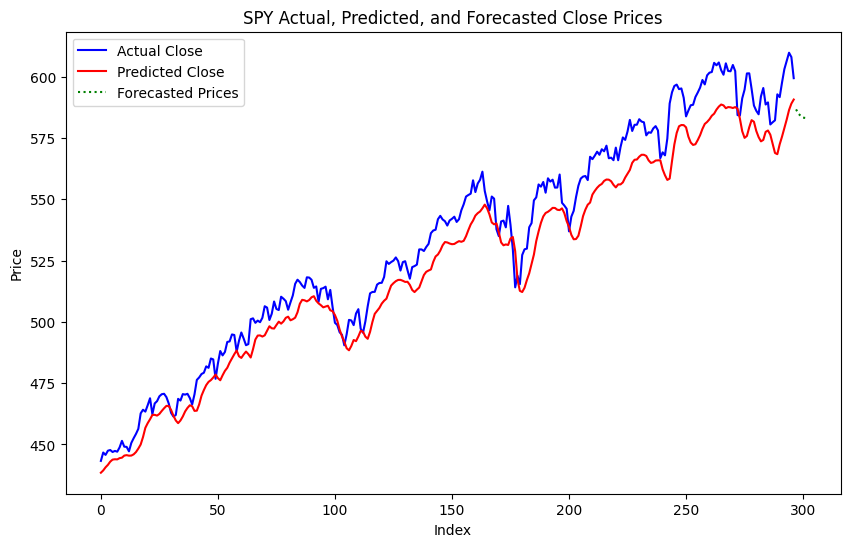

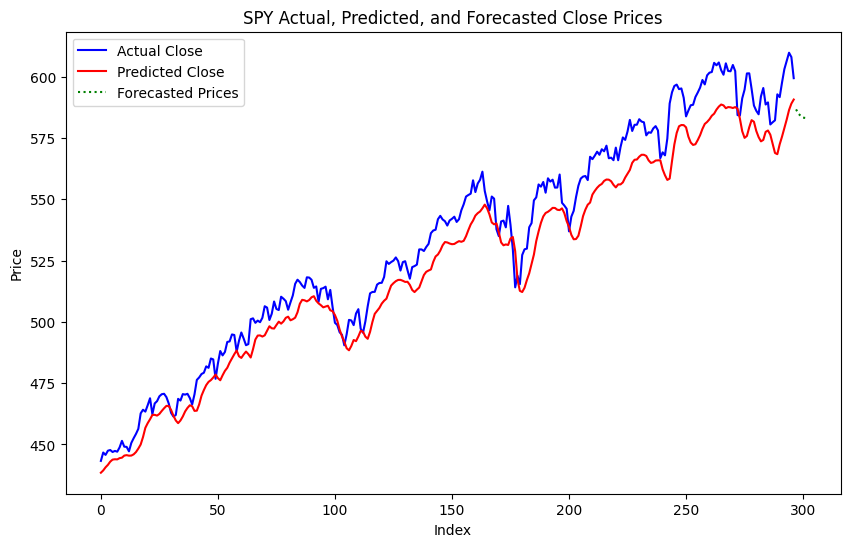

In [132]:
# 12) Plot results
# fig = plot_results(act_close, pred_close, future_predictions, forecast_days, ticker)
plot_results_matplotlib(act_close, pred_close, future_predictions, forecast_days, ticker)

In [58]:
# # 13) Save the model
# state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
# save_file(state_dict_cpu, "lstm_model.safetensors")
# print("Model saved as lstm_model.safetensors")

Model saved as lstm_model.safetensors


# Stop running here, below is for Gradio Integration (WIP)

In [61]:
# -------------------------------
# Modular Predict & Forecast Function
# -------------------------------
def predict_spy(ticker,
                start_date,
                end_date,
                prediction_days=1,
                sequence_length=30,
                epochs=10,
                forecast_days=5,
                hidden_size=64,
                num_layers=1,
                lr=1e-3,
                batch_size=32,
                model_version=None,
                use_hyperparam_tuning=False,
                n_trials=20,
                val_ratio=0.1,
                test_ratio=0.1):
    """Main function to fetch data, optionally from CSV cache, train the LSTM,
       and forecast future prices.
    """

    # Optional step: Hyperparameter Tuning
    if use_hyperparam_tuning:
        print("\n[Hyperparameter Tuning] Running Optuna...")
        best_params = tune_hyperparams(
            ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            sequence_length=sequence_length,
            prediction_days=prediction_days,
            n_epochs=epochs,  # how many epochs per trial
            val_ratio=val_ratio,
            test_ratio=test_ratio,
            n_trials=n_trials
        )
        # Override user-provided hyperparams with best from Optuna
        hidden_size = best_params["hidden_size"]
        num_layers = best_params["num_layers"]
        lr = best_params["lr"]
        batch_size = best_params["batch_size"]
        print(f"Using best hyperparameters: {best_params}")

    # 1) Try reading the latest CSV if present
    data = read_latest_data_csv(ticker, start_date, end_date)

    # If no CSV file is found, download via Yahoo Finance and save
    if data is None:
        data = download_data(ticker, start_date, end_date)
        save_data_to_csv(data, ticker, start_date, end_date)

    # 2) Scale data and create sequences
    X_all, y_all, data_scaled, scaler = scale_and_sequence(data, sequence_length, prediction_days)

    # 3) Split data into training and testing
    X_train, y_train, X_test, y_test = split_data(X_all, y_all)

    # 4) Create DataLoaders
    train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

    # 5) Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = data.shape[1]
    output_size = 1

     # 6) Load or train a model (versioned)
    model = get_or_train_model(
        train_loader,
        input_size,
        hidden_size,
        num_layers,
        output_size,
        epochs,
        lr,
        model_dir="models",     # directory for versioned files
        version=model_version   # can be None, or e.g. "v2", or a timestamp string
    )

    # 7) Additional training (optional)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_model(model, train_loader, optimizer, criterion, epochs, device)

    # 8) Evaluate on test set
    predictions, actuals = evaluate_model(model, test_loader, device)

    # 9) Inverse scale the predictions
    pred_close, act_close = inverse_scale_predictions(predictions, actuals, scaler, data.shape)

    # 10) Calculate RMSE
    mse  = np.mean((pred_close - act_close) ** 2)
    rmse = float(np.sqrt(mse))

    # 11) Forecast future prices
    future_predictions = forecast_prices(model, data_scaled, sequence_length, forecast_days, scaler, data.shape, device)

    # 12) Plot results
    fig = plot_results(act_close, pred_close, future_predictions, forecast_days, ticker)

    # 13) Save the model
    state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
    save_file(state_dict_cpu, "lstm_model.safetensors")
    print("Model saved as lstm_model.safetensors")

    return fig, rmse

In [ ]:
demo = gr.Interface(
    fn=predict_spy,
    inputs=[
        gr.Textbox(label="Enter Ticker Symbol", placeholder="e.g., SPY", value="SPY"),
        gr.Textbox(label="Start Date", value="2019-01-24"),
        gr.Textbox(label="End Date", value="2025-01-28"),
        gr.Slider(label="Prediction Days Ahead", minimum=1, maximum=30, value=1, step=1),
        gr.Slider(label="Sequence Length", minimum=10, maximum=200, value=60, step=5),
        gr.Slider(label="Number of Epochs", minimum=1, maximum=50, value=10, step=1),
        gr.Slider(label="Forecast Days", minimum=1, maximum=60, value=30, step=1),
        gr.Textbox(label="Model Version (optional)", placeholder="e.g., v1, v2, or leave empty"),
        gr.Checkbox(label="Use Hyperparameter Tuning?", value=False),
        gr.Slider(label="Optuna Trials", minimum=1, maximum=50, value=5, step=1, info="Number of Optuna search trials"),
    ],
    outputs=[
        gr.Plot(label="Predictions and Forecast"),
        gr.Number(label="RMSE")
    ],
    description=(
        "Enter a stock ticker symbol (e.g., SPY) to fetch historical data "
        "(or load from local CSV), choose training and forecasting parameters, "
        "and optionally specify a model version or enable hyperparameter tuning. "
        "If no version is specified, the 'latest' is attempted."
    )
)

In [63]:
# if __name__ == "__main__":
#     demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://780c71abfdf901a7ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
